In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math

In [2]:
url = 'https://raw.githubusercontent.com/Jneny/Hospitalcapacity/main/Data/icu_beds.csv'
data = read_csv(url, header=0, parse_dates=[0], index_col=0)
data = data.asfreq('d')
adultcrit = pd.DataFrame(data, columns=['adult_icu_crci_patients'])
sadultcrit = pd.Series(adultcrit.adult_icu_crci_patients)

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [4]:
#Convert pandas dataframe to numpy array
dataset = adultcrit.values
# dataset.dtype
dataset = dataset.astype('float32') #Convert values to float

In [5]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataset)

In [6]:
# len(dataset) = 655, want to predict last month or last 4 weeks = 655- (7*4) = 627
train, test = dataset[:627], dataset[627:]

In [7]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)

In [8]:
#input size first week then predict the next
seq_size = 7 
#Larger sequences (look further back) may improve forecasting.
trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

In [9]:
print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))

Shape of training set: (619, 7)
Shape of test set: (20, 7)


In [10]:
print('Build deep model...')
# create and fit dense model
model = Sequential()
model.add(Dense(64, input_dim=seq_size, activation='relu')) #12
model.add(Dense(32, activation='relu'))  #8
model.add(Dense(1)) # y value
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['acc'])
print(model.summary()) 

Build deep model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                512       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=20)


Epoch 1/20
20/20 - 0s - loss: 7.0560e-04 - acc: 0.0032 - val_loss: 0.0023 - val_acc: 0.0000e+00 - 70ms/epoch - 4ms/step
Epoch 2/20
20/20 - 0s - loss: 6.5614e-04 - acc: 0.0032 - val_loss: 0.0016 - val_acc: 0.0000e+00 - 43ms/epoch - 2ms/step
Epoch 3/20
20/20 - 0s - loss: 6.3274e-04 - acc: 0.0032 - val_loss: 7.5391e-04 - val_acc: 0.0000e+00 - 42ms/epoch - 2ms/step
Epoch 4/20
20/20 - 0s - loss: 6.4030e-04 - acc: 0.0032 - val_loss: 0.0015 - val_acc: 0.0000e+00 - 40ms/epoch - 2ms/step
Epoch 5/20
20/20 - 0s - loss: 5.3342e-04 - acc: 0.0032 - val_loss: 0.0012 - val_acc: 0.0000e+00 - 44ms/epoch - 2ms/step
Epoch 6/20
20/20 - 0s - loss: 4.8508e-04 - acc: 0.0032 - val_loss: 0.0010 - val_acc: 0.0000e+00 - 44ms/epoch - 2ms/step
Epoch 7/20
20/20 - 0s - loss: 4.4931e-04 - acc: 0.0032 - val_loss: 0.0015 - val_acc: 0.0000e+00 - 42ms/epoch - 2ms/step
Epoch 8/20
20/20 - 0s - loss: 4.1681e-04 - acc: 0.0032 - val_loss: 0.0011 - val_acc: 0.0000e+00 - 49ms/epoch - 2ms/step
Epoch 9/20
20/20 - 0s - loss: 3.8447

In [20]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [21]:
# Estimate model performance
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.

trainPredict = scaler.inverse_transform(trainPredict)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_inverse = scaler.inverse_transform([testY])


In [22]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape
print(MAPE(testY_inverse[0], testPredict[:,0]))
print(MAPE(testY_inverse[0], testPredict[:,0]))

3.8385024040152538
3.8385024040152538


In [23]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_inverse[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY_inverse[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 11.18 RMSE
Test Score: 20.67 RMSE


In [24]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict


In [25]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

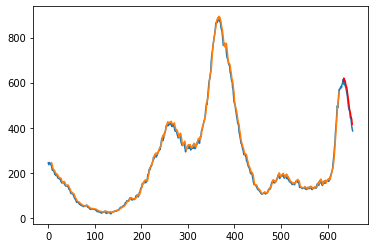

In [26]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot, color = 'r')
plt.show()